In [1]:
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import torch
%load_ext autoreload
%autoreload 2

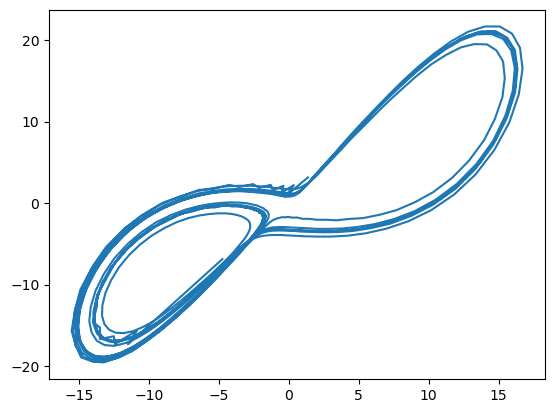

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(1000, resample=True,noise=0.01)
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])


In [3]:
#try official implementation of s4?
import sys
sys.path.append("/om2/user/ostrow/NN_delay_embeddings/s4")
from models.s4.s4 import S4Block as S4  # Can use full version instead of minimal S4D standalone below
from models.s4.s4d import S4D


CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [4]:
class OfficialS4Minimal(nn.Module):
    def __init__(self,d_input,d_output,d_model,d_state,dropout=0.0,prenorm=False,diagonal=True):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input,d_model)
        s4 = S4 if not diagonal else S4D

        self.s4 = s4(d_model,d_state=d_state,dropout=dropout)

        self.decoder = nn.Linear(d_model,d_output)
        self.norm = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model,4*d_model),
            nn.ReLU(),
            nn.Linear(4*d_model,d_output)
        )

    def forward(self,x):
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)

        z = x
        if self.prenorm:
            # Prenorm
            z = self.norm(z.transpose(-1, -2)).transpose(-1, -2)

        # Apply S4 block: we ignore the state input and output
        z, _ = self.s4(z)

        self.hiddens = z.transpose(-1, -2)  # (B, d_model, L) -> (B, L, d_model)

        # Residual connection
        x = z + x

        if not self.prenorm:
            # Postnorm
            x = self.norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Decode the outputs
        x = self.mlp(x)  # (B, d_model) -> (B, d_output)

        return x, None




In [5]:
model = OfficialS4Minimal(1,1,100,1000)

torch.Size([1, 1000, 1])
torch.Size([1, 1000, 1]) (1000, 100)


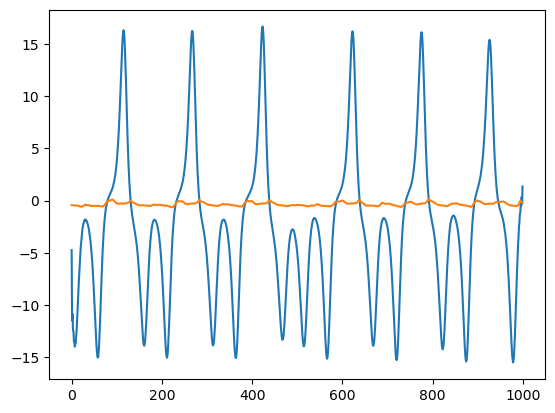

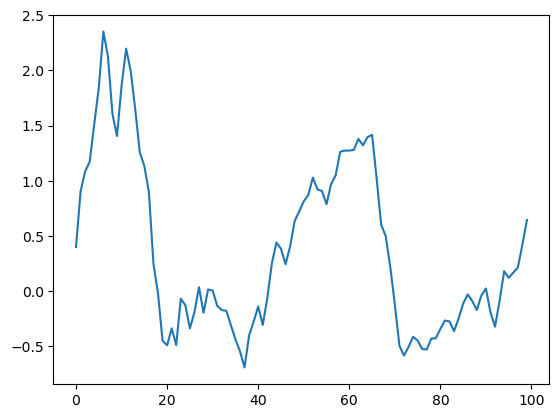

In [6]:
data = torch.tensor(sol[np.newaxis,:,:1]).float()
print(data.size())
plt.figure()
plt.plot(data[0,:,0])


out,_ = model(data)
hidden = model.hiddens.detach().numpy().squeeze()
print(out.shape, hidden.shape)
plt.plot(out.detach().numpy()[0,:,0])

plt.figure()
plt.plot(hidden[:100,0])

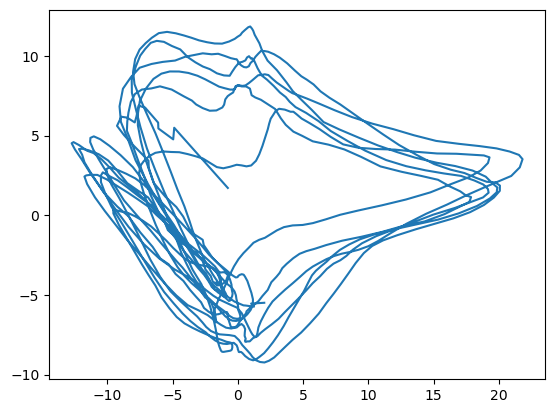

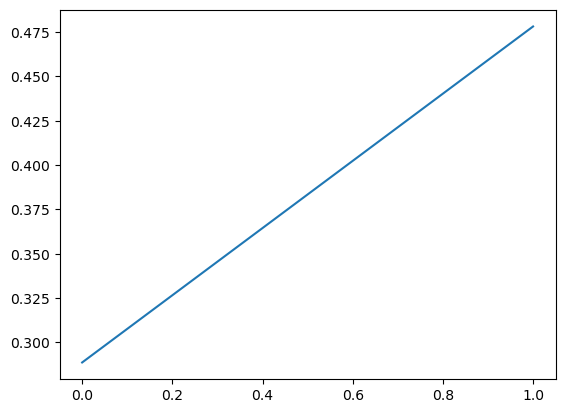

In [7]:
#run pca on the hidden states
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(hidden)
hidden_pca = pca.transform(hidden)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1])
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [8]:
from utils import make_dataset,train

train_loader, val_loader, train_data, val_data = make_dataset(Lorenz,2000,10)


(10, 2000, 3) torch.Size([10, 2000, 1])
(10, 2000, 3) torch.Size([10, 2000, 1])


In [15]:
from torch.optim import AdamW

model = OfficialS4Minimal(1,1,2,1000,dropout=0.1,prenorm=True,diagonal=True)

#model,train_set,val_set,epochs,lr,optimizer,loss_fn,device
all_train_loss = []
all_val_loss = []
for num_steps in [1,3,5,10]:
    model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-2,AdamW, nn.MSELoss(), 'cuda',num_steps)
    model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-3,AdamW, nn.MSELoss(), 'cuda',num_steps)
    all_train_loss.extend(train_loss)
    all_val_loss.extend(val_loss)

plt.plot(all_train_loss)
plt.plot(all_val_loss)

  2%|▏         | 1/50 [00:00<00:16,  2.98it/s]

Epoch 0 Training Loss: 52.91801071166992
Epoch 0 Validation Loss: 42.49788284301758


  4%|▍         | 2/50 [00:00<00:13,  3.53it/s]

Epoch 1 Training Loss: 35.05352592468262
Epoch 1 Validation Loss: 25.31949577331543


 10%|█         | 5/50 [00:00<00:06,  6.60it/s]

Epoch 2 Training Loss: 21.491483306884767
Epoch 2 Validation Loss: 14.155148220062255
Epoch 3 Training Loss: 8.591930723190307
Epoch 3 Validation Loss: 2.003106939792633
Epoch 4 Training Loss: 1.199533426761627
Epoch 4 Validation Loss: 1.6794897317886353


 14%|█▍        | 7/50 [00:01<00:05,  7.88it/s]

Epoch 5 Training Loss: 1.5934731006622314
Epoch 5 Validation Loss: 0.817897230386734
Epoch 6 Training Loss: 0.7281476795673371
Epoch 6 Validation Loss: 0.7528160512447357
Epoch 7 Training Loss: 0.7475518107414245


 18%|█▊        | 9/50 [00:01<00:05,  7.92it/s]

Epoch 7 Validation Loss: 0.6001379489898682
Epoch 8 Training Loss: 0.5959058284759522
Epoch 8 Validation Loss: 0.5510899394750595


 22%|██▏       | 11/50 [00:01<00:04,  8.87it/s]

Epoch 9 Training Loss: 0.5671141117811203
Epoch 9 Validation Loss: 0.5122274696826935
Epoch 10 Training Loss: 0.5316362470388413
Epoch 10 Validation Loss: 0.4925106793642044
Epoch 11 Training Loss: 0.5082341969013214
Epoch 11 Validation Loss: 0.4708586007356644


 30%|███       | 15/50 [00:01<00:03, 10.17it/s]

Epoch 12 Training Loss: 0.4871194452047348
Epoch 12 Validation Loss: 0.45427829027175903
Epoch 13 Training Loss: 0.4716708332300186
Epoch 13 Validation Loss: 0.43708977699279783
Epoch 14 Training Loss: 0.45216022729873656
Epoch 14 Validation Loss: 0.42079935073852537


 34%|███▍      | 17/50 [00:02<00:03,  8.71it/s]

Epoch 15 Training Loss: 0.43128147423267366
Epoch 15 Validation Loss: 0.4060630232095718
Epoch 16 Training Loss: 0.42733134925365446
Epoch 16 Validation Loss: 0.3985684275627136


 40%|████      | 20/50 [00:02<00:03,  9.17it/s]

Epoch 17 Training Loss: 0.41225957572460176
Epoch 17 Validation Loss: 0.38772851824760435
Epoch 18 Training Loss: 0.4095409482717514
Epoch 18 Validation Loss: 0.3786495476961136
Epoch 19 Training Loss: 0.39720846712589264
Epoch 19 Validation Loss: 0.37102187871932985


 44%|████▍     | 22/50 [00:02<00:02,  9.87it/s]

Epoch 20 Training Loss: 0.3825883775949478
Epoch 20 Validation Loss: 0.36421356797218324
Epoch 21 Training Loss: 0.39066203534603117
Epoch 21 Validation Loss: 0.35902941823005674
Epoch 22 Training Loss: 0.37277516424655915
Epoch 22 Validation Loss: 0.35775521099567414


 48%|████▊     | 24/50 [00:02<00:02, 10.30it/s]

Epoch 23 Training Loss: 0.36429057717323304
Epoch 23 Validation Loss: 0.35358761847019193
Epoch 24 Training Loss: 0.3776379495859146
Epoch 24 Validation Loss: 0.34951306581497193
Epoch 25 Training Loss: 0.3549014896154404


 52%|█████▏    | 26/50 [00:03<00:02, 10.23it/s]

Epoch 25 Validation Loss: 0.34978483617305756
Epoch 26 Training Loss: 0.3924584031105042
Epoch 26 Validation Loss: 0.35327651500701907


 56%|█████▌    | 28/50 [00:03<00:02,  9.08it/s]

Epoch 27 Training Loss: 0.35717974305152894
Epoch 27 Validation Loss: 0.3501297563314438
Epoch 28 Training Loss: 0.3850331872701645


 58%|█████▊    | 29/50 [00:03<00:02,  7.89it/s]

Epoch 28 Validation Loss: 0.35509332120418546
Epoch 29 Training Loss: 0.3658205807209015


 64%|██████▍   | 32/50 [00:03<00:02,  7.92it/s]

Epoch 29 Validation Loss: 0.34763493835926057
Epoch 30 Training Loss: 0.3455050528049469
Epoch 30 Validation Loss: 0.34089857935905454
Epoch 31 Training Loss: 0.38935997188091276
Epoch 31 Validation Loss: 0.3454843133687973


 68%|██████▊   | 34/50 [00:04<00:01,  8.83it/s]

Epoch 32 Training Loss: 0.3919238269329071
Epoch 32 Validation Loss: 0.36024706065654755
Epoch 33 Training Loss: 0.35229186415672303
Epoch 33 Validation Loss: 0.34137344658374785
Epoch 34 Training Loss: 0.35536847114562986
Epoch 34 Validation Loss: 0.34249578714370726


 76%|███████▌  | 38/50 [00:04<00:01, 10.15it/s]

Epoch 35 Training Loss: 0.3834714084863663
Epoch 35 Validation Loss: 0.3473780184984207
Epoch 36 Training Loss: 0.3817148745059967
Epoch 36 Validation Loss: 0.35655762553215026
Epoch 37 Training Loss: 0.3644403010606766
Epoch 37 Validation Loss: 0.3432616233825684


 80%|████████  | 40/50 [00:04<00:00, 10.49it/s]

Epoch 38 Training Loss: 0.3546255469322205
Epoch 38 Validation Loss: 0.3364526301622391
Epoch 39 Training Loss: 0.35243134796619413
Epoch 39 Validation Loss: 0.3344202786684036
Epoch 40 Training Loss: 0.3523396670818329
Epoch 40 Validation Loss: 0.3356092363595963


 88%|████████▊ | 44/50 [00:05<00:00, 10.97it/s]

Epoch 41 Training Loss: 0.3590157598257065
Epoch 41 Validation Loss: 0.33852414786815643
Epoch 42 Training Loss: 0.3665481716394424
Epoch 42 Validation Loss: 0.3381775110960007
Epoch 43 Training Loss: 0.3418993204832077
Epoch 43 Validation Loss: 0.33146037757396696


 92%|█████████▏| 46/50 [00:05<00:00, 11.08it/s]

Epoch 44 Training Loss: 0.33471194803714754
Epoch 44 Validation Loss: 0.33051404654979705
Epoch 45 Training Loss: 0.3537961483001709
Epoch 45 Validation Loss: 0.32907977104187014
Epoch 46 Training Loss: 0.35547976195812225
Epoch 46 Validation Loss: 0.3276757299900055


100%|██████████| 50/50 [00:05<00:00,  9.03it/s]


Epoch 47 Training Loss: 0.33620173335075376
Epoch 47 Validation Loss: 0.3265103787183762
Epoch 48 Training Loss: 0.33481266498565676
Epoch 48 Validation Loss: 0.3263606756925583
Epoch 49 Training Loss: 0.3578199684619904
Epoch 49 Validation Loss: 0.3306171208620071


  4%|▍         | 2/50 [00:00<00:04, 11.58it/s]

Epoch 0 Training Loss: 0.33296536207199096
Epoch 0 Validation Loss: 0.32313873171806334
Epoch 1 Training Loss: 0.3194716483354568
Epoch 1 Validation Loss: 0.3219692766666412
Epoch 2 Training Loss: 0.32595730423927305
Epoch 2 Validation Loss: 0.3206035226583481


 12%|█▏        | 6/50 [00:00<00:03, 11.41it/s]

Epoch 3 Training Loss: 0.3281192988157272
Epoch 3 Validation Loss: 0.3210690259933472
Epoch 4 Training Loss: 0.3331485718488693
Epoch 4 Validation Loss: 0.321552038192749
Epoch 5 Training Loss: 0.35143170952796937
Epoch 5 Validation Loss: 0.3236642926931381


 16%|█▌        | 8/50 [00:00<00:03, 11.49it/s]

Epoch 6 Training Loss: 0.3395767331123352
Epoch 6 Validation Loss: 0.31943397521972655
Epoch 7 Training Loss: 0.319879812002182
Epoch 7 Validation Loss: 0.31780592203140257
Epoch 8 Training Loss: 0.31284416913986207


 20%|██        | 10/50 [00:00<00:03, 10.92it/s]

Epoch 8 Validation Loss: 0.31695857644081116
Epoch 9 Training Loss: 0.31514478623867037
Epoch 9 Validation Loss: 0.31651703715324403
Epoch 10 Training Loss: 0.31986986100673676
Epoch 10 Validation Loss: 0.31534670293331146


 28%|██▊       | 14/50 [00:01<00:03, 11.17it/s]

Epoch 11 Training Loss: 0.3145215004682541
Epoch 11 Validation Loss: 0.31521704494953157
Epoch 12 Training Loss: 0.3193451315164566
Epoch 12 Validation Loss: 0.31458768248558044
Epoch 13 Training Loss: 0.3292327344417572
Epoch 13 Validation Loss: 0.3153315484523773


 32%|███▏      | 16/50 [00:01<00:03, 11.04it/s]

Epoch 14 Training Loss: 0.3088585168123245
Epoch 14 Validation Loss: 0.31532530188560487
Epoch 15 Training Loss: 0.32741110026836395
Epoch 15 Validation Loss: 0.31456736028194426
Epoch 16 Training Loss: 0.3386765718460083


 36%|███▌      | 18/50 [00:01<00:02, 10.79it/s]

Epoch 16 Validation Loss: 0.31246004104614256
Epoch 17 Training Loss: 0.3202032595872879
Epoch 17 Validation Loss: 0.3119057506322861
Epoch 18 Training Loss: 0.31638955771923066
Epoch 18 Validation Loss: 0.31047182679176333


 44%|████▍     | 22/50 [00:01<00:02, 11.23it/s]

Epoch 19 Training Loss: 0.3104054659605026
Epoch 19 Validation Loss: 0.3096688210964203
Epoch 20 Training Loss: 0.31900752186775205
Epoch 20 Validation Loss: 0.3081258624792099
Epoch 21 Training Loss: 0.3432211309671402
Epoch 21 Validation Loss: 0.3145293563604355


 48%|████▊     | 24/50 [00:02<00:02, 11.34it/s]

Epoch 22 Training Loss: 0.30770714282989503
Epoch 22 Validation Loss: 0.30766281485557556
Epoch 23 Training Loss: 0.3200390487909317
Epoch 23 Validation Loss: 0.30701636970043183
Epoch 24 Training Loss: 0.31546075344085694
Epoch 24 Validation Loss: 0.30525738298892974


 56%|█████▌    | 28/50 [00:02<00:01, 11.38it/s]

Epoch 25 Training Loss: 0.29968626201152804
Epoch 25 Validation Loss: 0.30523076355457307
Epoch 26 Training Loss: 0.2975930988788605
Epoch 26 Validation Loss: 0.30269297063350675
Epoch 27 Training Loss: 0.3105366140604019
Epoch 27 Validation Loss: 0.30273076593875886


 60%|██████    | 30/50 [00:02<00:01, 11.15it/s]

Epoch 28 Training Loss: 0.30836980044841766
Epoch 28 Validation Loss: 0.30212064981460574
Epoch 29 Training Loss: 0.3097449764609337
Epoch 29 Validation Loss: 0.3017938405275345
Epoch 30 Training Loss: 0.2943290337920189
Epoch 30 Validation Loss: 0.29915732741355894


 68%|██████▊   | 34/50 [00:03<00:01, 11.15it/s]

Epoch 31 Training Loss: 0.3088939219713211
Epoch 31 Validation Loss: 0.2977123349905014
Epoch 32 Training Loss: 0.3076207086443901
Epoch 32 Validation Loss: 0.2960870087146759
Epoch 33 Training Loss: 0.32735801339149473
Epoch 33 Validation Loss: 0.2973002314567566


 72%|███████▏  | 36/50 [00:03<00:01, 11.17it/s]

Epoch 34 Training Loss: 0.30969869047403337
Epoch 34 Validation Loss: 0.2948921978473663
Epoch 35 Training Loss: 0.29986284375190736
Epoch 35 Validation Loss: 0.2946750342845917
Epoch 36 Training Loss: 0.3253193452954292
Epoch 36 Validation Loss: 0.2929042041301727


 76%|███████▌  | 38/50 [00:03<00:01, 10.91it/s]

Epoch 37 Training Loss: 0.29623150527477266
Epoch 37 Validation Loss: 0.29062530398368835
Epoch 38 Training Loss: 0.3130668386816978
Epoch 38 Validation Loss: 0.29613322019577026


 80%|████████  | 40/50 [00:03<00:00, 10.24it/s]

Epoch 39 Training Loss: 0.3041719615459442
Epoch 39 Validation Loss: 0.2887973338365555
Epoch 40 Training Loss: 0.3101859509944916
Epoch 40 Validation Loss: 0.28717959225177764
Epoch 41 Training Loss: 0.2829926386475563
Epoch 41 Validation Loss: 0.28725303113460543


 88%|████████▊ | 44/50 [00:04<00:00, 10.30it/s]

Epoch 42 Training Loss: 0.3099693939089775
Epoch 42 Validation Loss: 0.2852603942155838
Epoch 43 Training Loss: 0.28692892789840696
Epoch 43 Validation Loss: 0.2860732764005661


 92%|█████████▏| 46/50 [00:04<00:00, 10.37it/s]

Epoch 44 Training Loss: 0.28908383548259736
Epoch 44 Validation Loss: 0.283487668633461
Epoch 45 Training Loss: 0.30130545496940614
Epoch 45 Validation Loss: 0.2846773684024811
Epoch 46 Training Loss: 0.31178396940231323
Epoch 46 Validation Loss: 0.2829909145832062


100%|██████████| 50/50 [00:04<00:00, 10.92it/s]

Epoch 47 Training Loss: 0.30532057732343676
Epoch 47 Validation Loss: 0.2814018249511719
Epoch 48 Training Loss: 0.28320887237787246
Epoch 48 Validation Loss: 0.28108085691928864
Epoch 49 Training Loss: 0.2964086979627609
Epoch 49 Validation Loss: 0.28311160802841184



  4%|▍         | 2/50 [00:00<00:09,  4.84it/s]

Epoch 0 Training Loss: 3.367958116531372
Epoch 0 Validation Loss: 0.32728048861026765
Epoch 1 Training Loss: 3.0151570796966554
Epoch 1 Validation Loss: 0.33249571621418


  6%|▌         | 3/50 [00:00<00:09,  5.10it/s]

Epoch 2 Training Loss: 2.573925018310547
Epoch 2 Validation Loss: 0.28423570692539213
Epoch 3 Training Loss: 2.4380429863929747


 10%|█         | 5/50 [00:00<00:08,  5.32it/s]

Epoch 3 Validation Loss: 0.2829591691493988
Epoch 4 Training Loss: 2.3683065533638
Epoch 4 Validation Loss: 0.27554442882537844


 12%|█▏        | 6/50 [00:01<00:08,  5.32it/s]

Epoch 5 Training Loss: 2.4578860998153687
Epoch 5 Validation Loss: 0.2830604910850525
Epoch 6 Training Loss: 2.4267099142074584


 14%|█▍        | 7/50 [00:01<00:08,  5.20it/s]

Epoch 6 Validation Loss: 0.28192479014396665


 16%|█▌        | 8/50 [00:01<00:08,  4.73it/s]

Epoch 7 Training Loss: 2.4091130256652833
Epoch 7 Validation Loss: 0.28347802758216856
Epoch 8 Training Loss: 2.441754412651062


 20%|██        | 10/50 [00:02<00:08,  4.96it/s]

Epoch 8 Validation Loss: 0.2785219520330429
Epoch 9 Training Loss: 2.3435402393341063
Epoch 9 Validation Loss: 0.2731358230113983


 22%|██▏       | 11/50 [00:02<00:07,  5.03it/s]

Epoch 10 Training Loss: 2.4951353073120117
Epoch 10 Validation Loss: 0.27104121297597883
Epoch 11 Training Loss: 2.4534645557403563


 26%|██▌       | 13/50 [00:02<00:07,  5.11it/s]

Epoch 11 Validation Loss: 0.26428369879722596
Epoch 12 Training Loss: 2.305978763103485
Epoch 12 Validation Loss: 0.2870325744152069


 28%|██▊       | 14/50 [00:02<00:06,  5.15it/s]

Epoch 13 Training Loss: 2.3004610657691957
Epoch 13 Validation Loss: 0.27784906327724457
Epoch 14 Training Loss: 2.246815001964569


 32%|███▏      | 16/50 [00:03<00:06,  5.27it/s]

Epoch 14 Validation Loss: 0.2552348107099533
Epoch 15 Training Loss: 2.0869324564933778
Epoch 15 Validation Loss: 0.24986206740140915


torch.Size([1, 1000, 1])
torch.Size([1, 1000, 1]) (1000, 10)


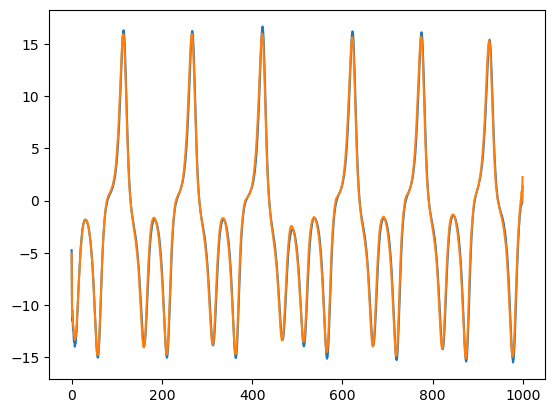

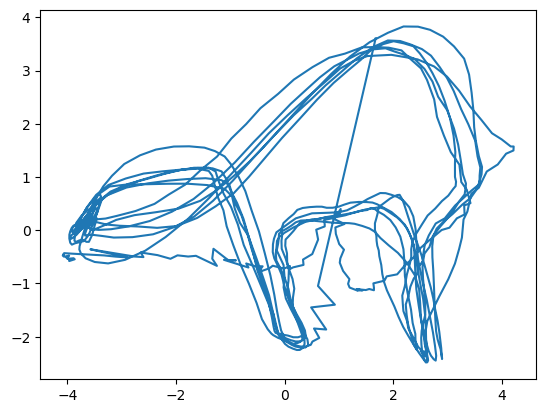

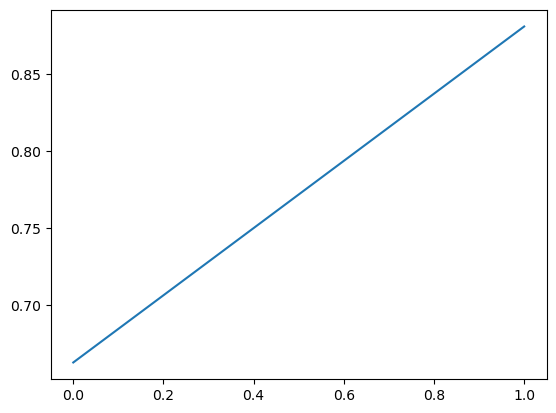

In [14]:
data = torch.tensor(sol[np.newaxis,:,:1]).float().cuda()
print(data.size())
plt.figure()
plt.plot(data[0,:,0].cpu())


out,_ = model(data)
hidden = model.hiddens.detach().cpu().numpy().squeeze()
print(out.shape, hidden.shape)
plt.plot(out.detach().cpu().numpy()[0,:,0])

#run pca on the hidden states
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(hidden)
hidden_pca = pca.transform(hidden)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1],label="reconstructed w PCA")
# plt.plot(sol[:,0],sol[:,1],label="original")
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
def hippo_initializer(dim):
    pass

def discretize_dplr(lambd,P,Q,B,C,step,l_max):
    pass

def scan_ssm(ssm,u,x0):
    pass

class minimalS4(nn.Module):
    def __init__(self, input_dim,d_model,n_head):
        super().__init__()

        


In [96]:
import math
from einops import rearrange, repeat

class S4D_rnn(nn.Module):
    #produces the A,B,C,D matrices that recapitulate the s4d kernel below
    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        pass


class S4DKernel(nn.Module):
    """Generate convolution kernel from diagonal SSM parameters."""

    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        super().__init__()
        # Generate dt
        H = d_model
        log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)

        C = torch.randn(H, N // 2, dtype=torch.cfloat)
        self.C = nn.Parameter(torch.view_as_real(C))
        self.register("log_dt", log_dt, lr)

        log_A_real = torch.log(0.5 * torch.ones(H, N//2))
        A_imag = math.pi * repeat(torch.arange(N//2), 'n -> h n', h=H)
        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

    def forward(self, L):
        """
        returns: (..., c, L) where c is number of channels (default 1)
        """

        # Materialize parameters
        dt = torch.exp(self.log_dt) # (H)
        C = torch.view_as_complex(self.C) # (H N)
        A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

        # Vandermonde multiplication
        dtA = A * dt.unsqueeze(-1)  # (H N)
        K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
        C = C * (torch.exp(dtA)-1.) / A
        K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real

        return K

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)

In [108]:
k = S4DKernel(2)
L = 4
self = k

dt = torch.exp(self.log_dt) # (H)
C = torch.view_as_complex(self.C) # (H N)
A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

# Vandermonde multiplication
dtA = A * dt.unsqueeze(-1)  # (H N)
K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
C = C * (torch.exp(dtA)-1.) / A
K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real
K

tensor([[ 0.0005,  0.0215,  0.0420,  0.0594],
        [-0.0892, -0.0363,  0.0305,  0.0749]], grad_fn=<MulBackward0>)